In [2]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT, force_remount=True)           # we mount the google drive at /content/drive

/content/drive
Mounted at /content/drive


In [3]:
%cd 'drive/My Drive/Workspaces/handwritten_character_recognition'

/content/drive/My Drive/Workspaces/handwritten_character_recognition


In [6]:
%pwd

'/content/drive/My Drive/Workspaces/handwritten_character_recognition'

# 1. Data Preparation


## 1.1 Download Dataset from Kaggle



In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d 'sachinpatel21/az-handwritten-alphabets-in-csv-format'

100% 185M/185M [00:01<00:00, 105MB/s]



In [ ]:
! unzip  az-handwritten-alphabets-in-csv-format.zip

Archive:  az-handwritten-alphabets-in-csv-format.zip
  inflating: A_Z Handwritten Data.csv  
  inflating: A_Z Handwritten Data/A_Z Handwritten Data.csv  


## 1.2 Prepare

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input, ZeroPadding2D, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils
import numpy as np
import pandas as pd
import os

In [5]:
data_csv = pd.read_csv('data/A_Z Handwritten Data.csv').astype('float32')
print(data_csv.head())
print(data_csv.shape)

     0  0.1  0.2  0.3  0.4  0.5  ...  0.643  0.644  0.645  0.646  0.647  0.648
0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0
1  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0
2  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0
3  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0
4  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0

[5 rows x 785 columns]
(372450, 785)


In [6]:
# lable = column 0
# rest are image data. 784 features
X = data_csv.iloc[:,1:]
y = data_csv.iloc[:,0]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [7]:
# 784 = 28x28... we need to reshape it to get our images
import numpy as np
X_train = np.reshape(X_train.values,(X_train.shape[0],28,28,1))
X_test = np.reshape(X_test.values,(X_test.shape[0],28,28,1))

In [8]:
# Labels are float values. 
y_train_encoded = to_categorical(y_train, num_classes = 26, dtype='int')
y_test_encoded = to_categorical(y_test, num_classes = 26, dtype='int')

In [9]:
# label letter map
import string
upper_case = string.ascii_uppercase
label_letter_map = {}
for idx, letter in enumerate(upper_case):
  label_letter_map[idx] = letter

print(label_letter_map)

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}


# 2. EDA

In [10]:
# View alphabet counts i.e. Target distribution
y_int =y.astype(int)
alphabet_counts = pd.DataFrame(y_int.value_counts()).reset_index()
alphabet_counts.columns = ['alphabet','count']
alphabet_counts.sort_values(by=['alphabet'],inplace=True)
alphabet_counts['alphabet'] = alphabet_counts['alphabet'].apply(lambda x: label_letter_map[x])
alphabet_counts

,alphabet,count
7,A,13869
15,B,8668
3,C,23409
14,D,10134
11,E,11440
24,F,1163
21,G,5762
17,H,7218
25,I,1120
16,J,8493


In [11]:
label_alphabets = pd.DataFrame(y_int)
label_alphabets.columns = ['alphabet']
label_alphabets['alphabet'] = label_alphabets['alphabet'].apply(lambda x: label_letter_map[x])
label_alphabets

,alphabet
0,A
1,A
2,A
3,A
4,A
...,...
372445,Z
372446,Z
372447,Z
372448,Z


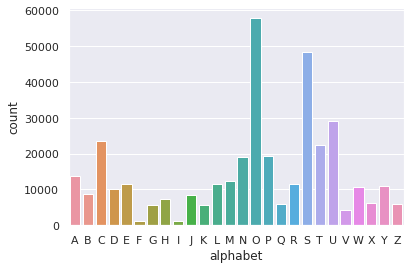

In [12]:
import seaborn as sns
sns.set_theme(style="darkgrid")
ax = sns.countplot(data = label_alphabets, x='alphabet')

# Creating model

In [ ]:
import time

dense_layers = [0,1,2]
layer_sizes = [32,64,128]
conv_layers = [1,2]

for dense_layer in dense_layers:
  for layer_size  in layer_sizes:
    for conv_layer in conv_layers:
      NAME = '{}-conv-{}-nodes-{}-dense-{}'.format(conv_layer, layer_size, dense_layer, int(time.time()))
      print(NAME)
      tensorboard = TensorBoard(log_dir='hcr_logs/{}'.format(NAME))
      model = Sequential()

      model.add(Conv2D(layer_size, (3, 3), input_shape=(28,28,1)))
      model.add(Activation('relu'))
      model.add(MaxPooling2D(pool_size=(2, 2)))

      for l in range(conv_layer - 1):
        model.add(Conv2D(layer_size, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

      model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

      # model.add(Dropout(0.5)) #this reduces the tendency of the model to overfit

      for l in range(dense_layer):
        model.add(Dense(layer_size))
        model.add(Activation('relu'))

      model.add(Dense(26))
      model.add(Activation('softmax'))

      model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

      # model.fit(X_train, y_train, batch_size=16, epochs=10,validation_split= 0.0, validation_data = (X_val, y_val), callbacks =[tensorboard])
      model.fit(X_train, y_train_encoded,  batch_size = 10, epochs = 2, validation_data = (X_test,y_test_encoded), callbacks=[tensorboard])

1-conv-32-nodes-0-dense-1602392388
Epoch 1/2
    1/29796 [..............................] - ETA: 18s - loss: 71.8066 - accuracy: 0.0000e+00WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
29796/29796 [==============================] - 88s 3ms/step - loss: 0.3007 - accuracy: 0.9375 - val_loss: 0.2049 - val_accuracy: 0.9449
Epoch 2/2
29796/29796 [==============================] - 84s 3ms/step - loss: 0.1726 - accuracy: 0.9559 - val_loss: 0.1755 - val_accuracy: 0.9613
2-conv-32-nodes-0-dense-1602392573
Epoch 1/2
29796/29796 [==============================] - 94s 3ms/step - loss: 0.2051 - accuracy: 0.9497 - val_loss: 0.1090 - val_accuracy: 0.9685
Epoch 2/2
29796/29796 [==============================] - 93s 3ms/step - loss: 0.1109 - accuracy: 0.9699 - val_loss: 0.11

In [ ]:
%load_ext tensorboard
%tensorboard --logdir hcr_logs

## Running on model with lowest validation loss

In [14]:
import time

dense_layers = [0]
layer_sizes = [128]
conv_layers = [2]

for dense_layer in dense_layers:
  for layer_size  in layer_sizes:
    for conv_layer in conv_layers:
      NAME = '{}-conv-{}-nodes-{}-dense-{}'.format(conv_layer, layer_size, dense_layer, int(time.time()))
      print(NAME)

      best_model = Sequential()

      best_model.add(Conv2D(layer_size, (3, 3), input_shape=(28,28,1)))
      best_model.add(Activation('relu'))
      best_model.add(MaxPooling2D(pool_size=(2, 2)))

      for l in range(conv_layer - 1):
        best_model.add(Conv2D(layer_size, (3, 3)))
        best_model.add(Activation('relu'))
        best_model.add(MaxPooling2D(pool_size=(2, 2)))

      best_model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

      # model.add(Dropout(0.5)) #this reduces the tendency of the model to overfit

      for l in range(dense_layer):
        best_model.add(Dense(layer_size))
        best_model.add(Activation('relu'))

      best_model.add(Dense(26))
      best_model.add(Activation('softmax'))

      best_model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

2-conv-128-nodes-0-dense-1602395329


In [15]:
checkpoint = ModelCheckpoint('hcr_model1-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

In [16]:
best_model.fit(X_train, y_train_encoded,  batch_size = 10, epochs = 2, validation_data = (X_test,y_test_encoded), callbacks=[checkpoint])

Epoch 1/2
29781/29796 [============================>.] - ETA: 0s - loss: 0.1716 - accuracy: 0.9568WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: hcr_model1-001.model/assets
29796/29796 [==============================] - 92s 3ms/step - loss: 0.1716 - accuracy: 0.9568 - val_loss: 0.1146 - val_accuracy: 0.9693
Epoch 2/2
29796/29796 [==============================] - 93s 3ms/step - loss: 0.0975 - accuracy: 0.9739 - val_loss: 0.0930 - val_accuracy: 0.9757


# Check Predictions


In [20]:
import cv2
import numpy as np
from keras.models import load_model
from google.colab.patches import cv2_imshow

model = load_model("hcr_model1-002.model")

In [30]:
img = np.reshape(X_test[65], (28,28))
cv2_imshow(img)
img_final =np.reshape(img, (1,28,28,1))

In [31]:
print(label_letter_map[np.argmax(model.predict(img_final))])

E
